In [ ]:
import file_path as fp
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import math
import collections
import os
from tensorflow.contrib.tensorboard.plugins import projector

In [104]:
mobile_data = pd.read_csv(fp.csv_folder+"mobile_data_info_train_competition.csv")
# convert floating points class types to integer. Empty class type is filled with -1
mobile_data[mobile_data.columns.values[3:]] = mobile_data[mobile_data.columns.values[3:]].fillna(-1.0).astype(int)

In [105]:
for col in mobile_data.columns.values:
    print(col, ": unique values =", len(mobile_data[col].unique()), ", non-empty rows =", len(mobile_data.dropna(subset=[col])))

itemid : unique values = 160330 , non-empty rows = 160330
title : unique values = 126719 , non-empty rows = 160330
image_path : unique values = 160330 , non-empty rows = 160330
Operating System : unique values = 8 , non-empty rows = 45278
Features : unique values = 8 , non-empty rows = 39345
Network Connections : unique values = 5 , non-empty rows = 23424
Memory RAM : unique values = 11 , non-empty rows = 57037
Brand : unique values = 56 , non-empty rows = 155038
Warranty Period : unique values = 15 , non-empty rows = 48073
Storage Capacity : unique values = 9 , non-empty rows = 63150
Color Family : unique values = 22 , non-empty rows = 84831
Phone Model : unique values = 620 , non-empty rows = 84509
Camera : unique values = 16 , non-empty rows = 24590
Phone Screen Size : unique values = 7 , non-empty rows = 32694


Looks like there are duplicated item titles

In [ ]:
freq_dict = dict()
for title in mobile_data.title.values:
  if title in freq_dict:
    freq_dict[title] += 1
  else:
    freq_dict[title] = 1
for k, v in freq_dict.items():
  if v > 1:
    print(k)

In [ ]:
mobile_data[mobile_data.title == "wa 6281934445554 spesial promo akhir bulan beli 2 gratis 1 kusus ini diskon seru samsung"]

In [ ]:
def is_phone_number(string):
  if len(string) <= 3:
    return False
  digit_count = 0
  for char in string:
    if char.isdigit():
      digit_count += 1
      
  if digit_count > 3:
    return True
  
  return False

In [ ]:
vocabulary  = list()

for line in mobile_data.title.values:
  tokens = line.split()
  for token in tokens:
    # remove telephone numbers
    if len(token) == 1 and not token.isdigit():
      continue
    if is_phone_number(token):
      continue
      
    vocabulary.append(token)
    
print('Data size', len(vocabulary))

In [ ]:
import collections

vocabulary_size = 300

def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)
# del vocabulary  # Hint to reduce memory.
print('Most common words', count[1:6])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])
print("length of the dictionary: ", len(reverse_dictionary), "should be equal to", vocabulary_size)

In [ ]:
# calculate Term Frequency - Inverse Term Frequency for most common words
known_word_set = set([word for word, _ in count[1:]])

In [ ]:
term_freq = dict()
inverse_term_freq = dict()
term_document_count = dict()
for itemid, title in mobile_data[["itemid", "title"]].values:
  tokens = title.split()
  unique_tokens = set()
  for token in tokens:
    if token not in known_word_set:
      continue
    if (itemid, token) in term_freq:
      term_freq[(itemid, token)] += 1
    else:
      term_freq[(itemid, token)] = 1
    unique_tokens.add(token)
    
  for token in unique_tokens:
    if token in term_document_count:
      term_document_count[token] += 1
    else:
      term_document_count[token] = 1  

n_documents = len(mobile_data)
for token, count in term_document_count.items():
  inverse_term_freq[token] = math.log(n_documents / count)

In [ ]:
# no word is repeated in each title
for k, v in term_freq.items():
  if v > 1:
    print(k)

In [ ]:
data_index = 0

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
      data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

In [87]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 32  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Look up embeddings for inputs.
  with tf.name_scope('embeddings'):
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
  with tf.name_scope('weights'):
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size))
    )
  with tf.name_scope('biases'):
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer using a learning rate of 1.0.
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
  saver = tf.train.Saver()

In [88]:
log_dir = "D:/NDSC_2019/tf_logs/"

In [89]:
# Step 5: Begin training.
num_steps = 40001

with tf.Session(graph=graph) as session:
#   Open a writer to write summaries.
  writer = tf.summary.FileWriter(log_dir, session.graph)

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    # Add returned summaries to writer in each step.
    writer.add_summary(summary, step)
    # Add metadata to visualize the graph for the last run.
    if step == (num_steps - 1):
      writer.add_run_metadata(run_metadata, 'step%d' % step)

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s: %s' % (valid_word, ", ".join([reverse_dictionary[k] for k in nearest]))
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

  # Write corresponding labels for the embeddings.
#   with open(log_dir + '/metadata.tsv', 'w') as f:
#     for i in range(vocabulary_size):
#       f.write(reverse_dictionary[i] + '\n')

  # Save the model for checkpoints.
#   saver.save(session, os.path.join(log_dir, 'model.ckpt'))

  # Create a configuration for visualizing embeddings with the labels in TensorBoard.
#   config = projector.ProjectorConfig()
#   embedding_conf = config.embeddings.add()
#   embedding_conf.tensor_name = embeddings.name
#   embedding_conf.metadata_path = os.path.join(log_dir, 'metadata.tsv')
#   projector.visualize_embeddings(writer, config)

writer.close()

Initialized
Average loss at step  0 :  89.16680908203125
Nearest to chat: neo, gray, no, 5a, huawei, prime, cuci, usb
Nearest to black: lite, on, gb, tahun, bluetooth, mulus, lenovo, 8gb
Nearest to sony: armor, spigen, dijual, ex, bonus, phone, samsung, bisa
Nearest to second: matte, touchscreen, 8gb, thn, 5, 256gb, note, screen
Nearest to lcd: berkualitas, seken, a5, core, sein, a83, premium, murah
Nearest to lte: skin, v7, warna, a71, android, 5.5, internal, baterai
Nearest to hari: terlaris, bm, kamera, serius, 1gb, pro, max, plus
Nearest to plus: 6, kamera, phone, termurah, back, zb602kl, hari, internal
Nearest to ram: emas, a39, biru, garansi, core, hard, nokia, a7
Nearest to tam: berkualitas, leather, v5, a5, s7, premium, bulan, special
Nearest to f5: s2, 32gb, info, selfie, evercoss, bisa, flip, only
Nearest to asus: lewat, terlaris, soft, realme, sale, 105, kamera, serius
Nearest to s8: prime, f3, v11, single, z3, new, 7, a57
Nearest to original: full, a71, j7, internasional, 6

In [90]:
# Step 6: Visualize the embeddings.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = min(500, vocabulary_size)
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]

def plot_with_labels(low_dim_embs, labels):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
  return plt

[]

[]

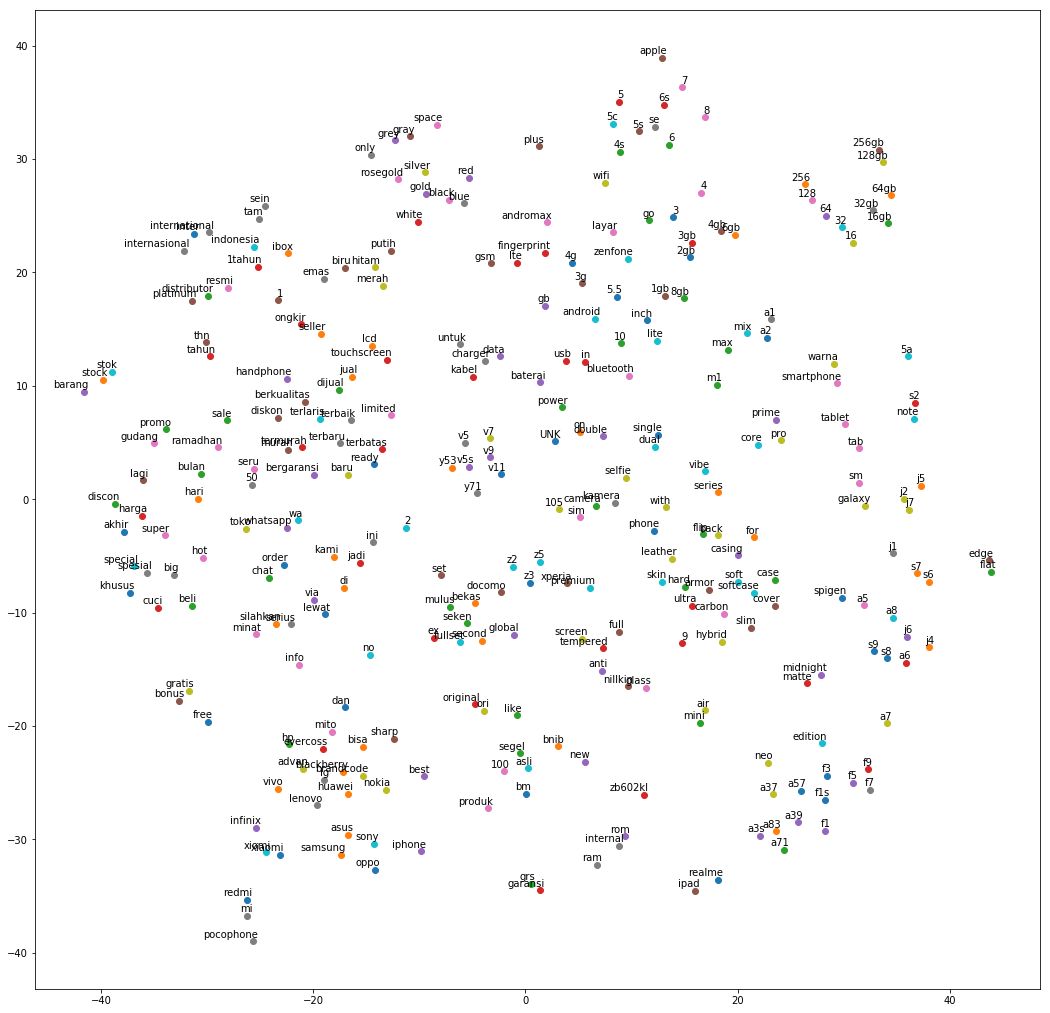

In [91]:
plot_with_labels(low_dim_embs, labels).plot()

Let's try to calculate the feature vector for each title using the the TF-IDF weighted word vector of known words

In [107]:
def get_avg_title_vector(itemid, title):
  tokens = title.split()
  total_score = 0
  total_vec = np.zeros(embedding_size)
  for token in tokens:
    if token not in known_word_set:
      continue
    word_vec = final_embeddings[dictionary[token]]
    tf_idf_score = term_freq[(itemid, token)] * inverse_term_freq[token]
    total_score += tf_idf_score
    total_vec += word_vec * tf_idf_score
  
  if total_score == 0:
    return np.nan
  return total_vec / total_score

mobile_data["title_vector"] = mobile_data.apply(lambda x: get_avg_title_vector(x.itemid, x.title), axis=1)

In [108]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(mobile_data.dropna(subset=['title_vector']), test_size=0.2)

In [118]:
from sklearn.ensemble import RandomForestClassifier

y_col = "Operating System"

clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
clf.fit(np.stack(train.title_vector.values), train[y_col])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [121]:
from sklearn.metrics import confusion_matrix

labels = mobile_data[y_col].unique()
labels.sort()

print(labels)
print(confusion_matrix(test[y_col].values, clf.predict(np.stack(test.title_vector.values)),
                 labels=labels))

[-1  0  1  2  3  4  5  6]
[[21740     1    61     4    18     0     0  1025]
 [   24     8     0     0     0     0     0     0]
 [  967     0   151     0     0     0     0    10]
 [   49     0     0     4     0     0     0     2]
 [  240     0     0     0    57     0     0    15]
 [    1     0     0     0     0     0     0     0]
 [    4     0     0     0     0     0     0     0]
 [ 5379     0     7     1     4     0     0  2071]]


In [95]:
clf.feature_importances_

array([0.02888665, 0.03031161, 0.03027442, 0.03186746, 0.03161858,
       0.02878368, 0.02876984, 0.03311716, 0.03022083, 0.0310834 ,
       0.02870923, 0.03029523, 0.02973248, 0.02937732, 0.0364959 ,
       0.03255857, 0.04338707, 0.0296046 , 0.02761872, 0.0274389 ,
       0.04169796, 0.02939365, 0.02773502, 0.0337993 , 0.03853657,
       0.02989361, 0.02834593, 0.02989443, 0.03294307, 0.02978625,
       0.02874537, 0.02907716])

In [ ]:
from PIL import Image

In [ ]:
im = Image.open(fp.image_base_folder+"mobile_image/70e0d8ddd69692b0f134498efbddf4e1.jpg")

In [ ]:
print(im.format, im.size, im.mode)